Dataset: https://archive.ics.uci.edu/dataset/204/pems+sf

Preprocessing: https://github.com/rohanmohapatra/tft-transformer-keras/tree/master

In [ ]:
import numpy as np
from time import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil
import pandas as pd
from time import time
import pickle as pkl
from keras.callbacks import EarlyStopping
import math


# Standard libraries
import os
import math
from time import time
from pprint import pprint
from typing import Dict, Any, Tuple

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine learning
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific computing
from scipy.fft import fft, ifft

# File I/O
import pickle as pkl
import shutil

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00204/PEMS-SF.zip

--2024-10-12 23:09:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00204/PEMS-SF.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘PEMS-SF.zip’

PEMS-SF.zip             [            <=>     ] 104.41M  45.7MB/s    in 2.3s    

2024-10-12 23:09:22 (45.7 MB/s) - ‘PEMS-SF.zip’ saved [109480788]



In [ ]:
!unzip PEMS-SF.zip -d data

Archive:  PEMS-SF.zip
  inflating: data/PEMS_test          
  inflating: data/PEMS_testlabels    
  inflating: data/PEMS_train         
  inflating: data/PEMS_trainlabels   
  inflating: data/randperm           
  inflating: data/stations_list      


In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time

In [ ]:
import numpy as np
from time import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
from time import time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import pickle as pkl

In [ ]:
data = pd.read_csv("drive/MyDrive/CS297/Datasets/traffic_features.csv", nrows=10000)

In [ ]:
df = data[["values", 'sensor_day', 'time_on_day', 'day_of_week', 'hours_from_start']]
df = df[[c for c in df if c not in ['values']] + ['values']]

# Keep columns with higher absolute correlation of 50%
corr_matrix = df.corr()
high_corr_cols = corr_matrix[abs(corr_matrix['values']) > 0.5].index
data = df[high_corr_cols].copy()

xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
df[[c for c in df if c not in ['values']]] = xScaler.fit_transform(df[[c for c in df if c not in ['values']]])
df[["values"]] = yScaler.fit_transform(df[["values"]])
newDfArray = df.to_numpy()

In [ ]:
class TimeLimitCallback(Callback):
    """
    Callback to stop training after a specified time limit.

    Attributes:
        start_time (float): The time when training begins.
        time_limit (float): The maximum allowed training time in seconds.
    """
    def __init__(self, time_limit: float):
        super(TimeLimitCallback, self).__init__()
        self.start_time: float = 0
        self.time_limit: float = time_limit

    def on_train_begin(self, logs: Dict[str, Any] = None) -> None:
        """Set the start time when training begins."""
        self.start_time = time()

    def on_epoch_end(self, epoch: int, logs: Dict[str, Any] = None) -> None:
        """Check if time limit is exceeded and stop training if so."""
        if time() - self.start_time > self.time_limit:
            self.model.stop_training = True
            print(f"Training stopped after {time() - self.start_time} seconds.")

class LossThresholdCallback(Callback):
    """
    Callback to stop training when a specified loss threshold is reached.

    Attributes:
        threshold (float): The loss threshold at which to stop training.
    """
    def __init__(self, threshold: float):
        super(LossThresholdCallback, self).__init__()
        self.threshold: float = threshold

    def on_epoch_end(self, epoch: int, logs: Dict[str, Any] = None) -> None:
        """Check if loss threshold is reached and stop training if so."""
        logs = logs or {}
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        if loss is not None and loss <= self.threshold:
            print(f"\nReached training loss of {self.threshold}, stopping training.")
            self.model.stop_training = True
        elif val_loss is not None and val_loss <= self.threshold:
            print(f"\nReached validation loss of {self.threshold}, stopping training.")
            self.model.stop_training = True

def series_to_window_series(time_series: np.ndarray, window_size: int) -> np.ndarray:
    """
    Convert a time series to a windowed series.

    Args:
        time_series (np.ndarray): The input time series.
        window_size (int): The size of the sliding window.

    Returns:
        np.ndarray: The windowed time series.
    """
    rows, cols = time_series.shape
    num_windows = rows - window_size + 1
    windows = np.lib.stride_tricks.sliding_window_view(time_series, (window_size, 1))
    return windows.reshape(num_windows, cols, window_size)

def window_series_to_series(window_series: np.ndarray) -> np.ndarray:
    """
    Convert a windowed series back to a regular time series.

    Args:
        window_series (np.ndarray): The windowed time series.

    Returns:
        np.ndarray: The reconstructed time series.
    """
    if window_series.ndim == 2:
        tmp_shape = window_series.shape
        window_series = window_series.reshape((tmp_shape[0], 1, tmp_shape[1]))

    num_windows, cols, window_size = window_series.shape
    original_length = num_windows + window_size - 1
    result = np.zeros((original_length, cols))

    indices = np.arange(window_size)[:, None] + np.arange(num_windows)
    np.add.at(result, indices, window_series.transpose((2, 0, 1)))

    counts = np.zeros((original_length, cols))
    np.add.at(counts, indices, 1)
    result /= counts

    return np.asarray(result, dtype=window_series.dtype)

def time_series_to_frequencies(time_series: np.ndarray, sampling_frequency: float = 1,
                               mask_percent: float = 0, mask_lower: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a time series to frequency domain.

    Args:
        time_series (np.ndarray): The input time series.
        sampling_frequency (float): The sampling frequency of the time series.
        mask_percent (float): Percentage of frequencies to mask.
        mask_lower (bool): Whether to mask lower frequencies.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Frequencies and their intensities.
    """
    intensities = fft(time_series)
    frequencies = np.fft.fftfreq(len(intensities), 1/sampling_frequency)

    if mask_percent > 0:
        mask_index = int(len(frequencies) * (mask_percent if mask_lower else 1 - mask_percent))
        frequencies = frequencies[mask_index:] if mask_lower else frequencies[:mask_index]

    return frequencies, intensities

def frequencies_to_time_series(frequencies: np.ndarray, complex_array_shape: Tuple[int, ...],
                               mask_percent: float = 0, mask_lower: bool = False) -> np.ndarray:
    """
    Convert frequency domain back to time series.

    Args:
        frequencies (np.ndarray): The input frequencies.
        complex_array_shape (Tuple[int, ...]): The shape of the complex array.
        mask_percent (float): Percentage of frequencies to mask.
        mask_lower (bool): Whether to mask lower frequencies.

    Returns:
        np.ndarray: The reconstructed time series.
    """
    if not np.iscomplex(frequencies).any():
        frequencies = unflatten_complex_array(frequencies, complex_array_shape)
    time_series = ifft(frequencies).real
    return time_series

def flatten_complex_array(complex_array: np.ndarray) -> Tuple[np.ndarray, Tuple[int, ...]]:
    """
    Flatten a complex array into a real array.

    Args:
        complex_array (np.ndarray): The input complex array.

    Returns:
        Tuple[np.ndarray, Tuple[int, ...]]: Flattened array and original shape.
    """
    complex_array_shape = complex_array.shape
    real, imag = complex_array.real, complex_array.imag
    flattened_array = np.concatenate((real, imag))
    return flattened_array, complex_array_shape

def unflatten_complex_array(flattened_array: np.ndarray, complex_array_shape: Tuple[int, ...]) -> np.ndarray:
    """
    Unflatten a real array back into a complex array.

    Args:
        flattened_array (np.ndarray): The flattened real array.
        complex_array_shape (Tuple[int, ...]): The shape of the original complex array.

    Returns:
        np.ndarray: The reconstructed complex array.
    """
    complex_array_length = len(flattened_array) // 2
    real = flattened_array[:complex_array_length]
    imag = flattened_array[complex_array_length:]
    complex_array = np.empty(complex_array_shape, dtype=np.complex128)
    complex_array.real = real
    complex_array.imag = imag
    return complex_array

def sliding_window_time_series_to_sliding_window_frequencies(sliding_window_time_series: np.ndarray,
                                                             sampling_frequency: float = 1,
                                                             flatten_complex: bool = True,
                                                             mask_percent: float = 0,
                                                             mask_lower: bool = True) -> Tuple[np.ndarray, Tuple[int, ...]]:
    """
    Convert a sliding window time series to sliding window frequencies.

    Args:
        sliding_window_time_series (np.ndarray): The input sliding window time series.
        sampling_frequency (float): The sampling frequency of the time series.
        flatten_complex (bool): Whether to flatten the complex array.
        mask_percent (float): Percentage of frequencies to mask.
        mask_lower (bool): Whether to mask lower frequencies.

    Returns:
        Tuple[np.ndarray, Tuple[int, ...]]: Sliding window frequencies and complex array shape.
    """
    sliding_window_frequencies = []
    num_sliding_windows, num_features, _ = sliding_window_time_series.shape
    complex_array_shape = None

    for sliding_window_index in range(num_sliding_windows):
        feature_sliding_window = []
        for feature_index in range(num_features):
            _, frequencies = time_series_to_frequencies(sliding_window_time_series[sliding_window_index, feature_index, :],
                                                        sampling_frequency, mask_percent, mask_lower)
            if flatten_complex:
                frequencies, complex_array_shape = flatten_complex_array(frequencies)
            feature_sliding_window.append(frequencies)
        sliding_window_frequencies.append(feature_sliding_window)

    return np.array(sliding_window_frequencies), complex_array_shape

def sliding_window_frequencies_to_sliding_window_time_series(sliding_window_frequencies: np.ndarray,
                                                             complex_array_shape: Tuple[int, ...]) -> np.ndarray:
    """
    Convert sliding window frequencies back to sliding window time series.

    Args:
        sliding_window_frequencies (np.ndarray): The input sliding window frequencies.
        complex_array_shape (Tuple[int, ...]): The shape of the complex array.

    Returns:
        np.ndarray: The reconstructed sliding window time series.
    """
    if sliding_window_frequencies.ndim == 2:
        tmp_shape = sliding_window_frequencies.shape
        sliding_window_frequencies = sliding_window_frequencies.reshape((tmp_shape[0], 1, tmp_shape[1]))

    sliding_window_time_series = np.apply_along_axis(lambda x: frequencies_to_time_series(x, complex_array_shape),
                                                     axis=2, arr=sliding_window_frequencies)
    return sliding_window_time_series

def plot_expected_predicted_data(expected_series: np.ndarray, predicted_series: np.ndarray,
                                 image_path: str = None, title: str = "Expected vs Predicted") -> None:
    """
    Plot expected and predicted data.

    Args:
        expected_series (np.ndarray): The expected time series.
        predicted_series (np.ndarray): The predicted time series.
        image_path (str, optional): Path to save the plot image.
        title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(20, 6))
    plot_expected = expected_series[1:]
    plot_predicted = predicted_series[1:]
    ax.plot(plot_expected, label='Expected')
    ax.plot(plot_predicted, label='Predicted')
    ax.set_title(title)
    ax.legend()
    plt.show()

def evaluate(expected: np.ndarray, predicted: np.ndarray) -> Dict[str, float]:
    """
    Evaluate model performance using various metrics.

    Args:
        expected (np.ndarray): The expected values.
        predicted (np.ndarray): The predicted values.

    Returns:
        Dict[str, float]: A dictionary of evaluation metrics.
    """
    mse = mean_squared_error(expected, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(expected, predicted)
    r2 = r2_score(expected, predicted)
    mape = np.mean(np.abs((expected - predicted) / expected)) * 100
    explained_var = explained_variance_score(expected, predicted)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'explained_variance': explained_var
    }

def prepare_lstm_training_data(time_series: np.ndarray, window_size: int, forecast_horizon: int,
                               test_ratio: float, val_ratio: float, frequency: bool = False) -> Tuple[np.ndarray, ...]:
    """
    Prepare data for LSTM model training.

    Args:
        time_series (np.ndarray): The input time series.
        window_size (int): The size of the sliding window.
        forecast_horizon (int): The number of future time steps to predict.
        test_ratio (float): The ratio of data to use for testing.
        val_ratio (float): The ratio of training data to use for validation.
        frequency (bool): Whether to use frequency domain data.

    Returns:
        Tuple[np.ndarray, ...]: Training, validation, and test data splits.
    """
    features = time_series
    target = time_series[:, -1].reshape(-1, 1)

    X = series_to_window_series(features, window_size)
    y = series_to_window_series(target, forecast_horizon)

    X = X[:-forecast_horizon]
    y = y[window_size:]

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )

    val_size_adjusted = val_ratio / (1 - test_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted, shuffle=False
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

def prepare_fdn_training_data(time_series: np.ndarray, window_size: int, forecast_horizon: int,
                              test_ratio: float, val_ratio: float, frequency: bool = False,
                              mask_percent: float = 0, mask_lower: bool = True,
                              use_pca: bool = False, pca_var_exp_ratio: float = 0.95) -> Tuple[Tuple[np.ndarray, ...], Tuple[np.ndarray, ...], Tuple[int, ...]]:
    """
    Prepare data for FDN model training.

    Args:
        time_series (np.ndarray): The input time series.
        window_size (int): The size of the sliding window.
        forecast_horizon (int): The number of future time steps to predict.
        test_ratio (float): The ratio of data to use for testing.
        val_ratio (float): The ratio of training data to use for validation.
        frequency (bool): Whether to use frequency domain data.
        mask_percent (float): Percentage of frequencies to mask.
        mask_lower (bool): Whether to mask lower frequencies.
        use_pca (bool): Whether to use PCA for dimensionality reduction.
        pca_var_exp_ratio (float): The desired explained variance ratio for PCA.

    Returns:
        Tuple[Tuple[np.ndarray, ...], Tuple[np.ndarray, ...], Tuple[int, ...]]:
        Time series data splits, frequency data splits, and target complex array shape.
    """

    features = time_series[:, :-1]
    target = time_series[:, -1].reshape(-1, 1)

    X = series_to_window_series(features, window_size)
    y = series_to_window_series(target, forecast_horizon)

    X = X[:-forecast_horizon]
    y = y[window_size:]

    X_freq, _ = sliding_window_time_series_to_sliding_window_frequencies(X)
    y_freq, target_complex_array_shape = sliding_window_time_series_to_sliding_window_frequencies(y)

    X_freq = X_freq.reshape((X_freq.shape[0], X_freq.shape[1] * X_freq.shape[2]))
    y_freq = y_freq.reshape((y_freq.shape[0], y_freq.shape[1] * y_freq.shape[2]))

    X_freq_train_val, X_freq_test, y_freq_train_val, y_freq_test = train_test_split(
        X_freq, y_freq, test_size=test_ratio, shuffle=False
    )

    val_size_adjusted = val_ratio / (1 - test_ratio)
    X_freq_train, X_freq_val, y_freq_train, y_freq_val = train_test_split(
        X_freq_train_val, y_freq_train_val, test_size=val_size_adjusted, shuffle=False
    )

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted, shuffle=False
    )

    time_series_data = (X_train, y_train, X_val, y_val, X_test, y_test)
    frequencies_data = (X_freq_train, y_freq_train, X_freq_val, y_freq_val, X_freq_test, y_freq_test)

    return time_series_data, frequencies_data, target_complex_array_shape

In [ ]:
def build_balanced_lstm_model(num_input_features, window_size, forecast_horizon, total_trainable_params, max_layer_width, min_layer_width):
    input_shape = (num_input_features, window_size)

    model = Sequential()

    # Add LSTM layer
    # print("LSTM_UNITS_REQUIRED:", total_trainable_params // (4 * (input_shape[1] + 1)))
    lstm_units = min(max_layer_width, total_trainable_params // (4 * (input_shape[1] + 1)))
    model.add(LSTM(units=lstm_units, input_shape=input_shape))

    # Calculate remaining parameters for dense layers
    lstm_params = lstm_units * (4 * (input_shape[1] + lstm_units + 1))
    remaining_params = total_trainable_params - lstm_params

    # Add dense layers
    dense_layers = []
    while remaining_params > 0:
        if len(dense_layers) == 0:
            input_dim = lstm_units
        else:
            input_dim = dense_layers[-1]

        output_dim = min(remaining_params // (input_dim + 1), max_layer_width)
        if output_dim < min_layer_width:
            break

        dense_layers.append(output_dim)
        remaining_params -= output_dim * (input_dim + 1)

    # Add dense layers to the model
    for units in dense_layers[:-1]:
        model.add(Dense(units=units, activation='relu'))

    # Add final dense layer for output
    model.add(Dense(units=forecast_horizon))

    # Verify total trainable parameters
    actual_params = model.count_params()

    if actual_params != total_trainable_params:
        print(f"Warning: Actual trainable parameters ({actual_params}) differ from requested ({total_trainable_params})")


    # Compile model with AdamW optimizer
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True,)

    # Print summary for debugging
    # model.summary()
    return model

# Usage
# model = build_balanced_lstm_model(WindowSize=50, X_train=X_train, ForecastHorizon=5, total_trainable_params=80000)

In [ ]:
def build_balanced_densenet_model(num_input_features, forecast_horizon, total_trainable_params, max_layer_width, min_layer_width, layer_width_decay=1):
    input_shape = (num_input_features,)

    model = Sequential()

    # Calculate number of layers and units per layer
    remaining_params = total_trainable_params
    dense_layers = []
    input_dim = input_shape[0]

    # Define a decay factor for layer sizes
    decay_factor = layer_width_decay

    while remaining_params > 0:
        if len(dense_layers) == 0:
            output_dim = max_layer_width
        else:
            output_dim = max(int(dense_layers[-1] * decay_factor), min_layer_width)

        output_dim = min(output_dim, remaining_params // (input_dim + 1))

        if output_dim < min_layer_width:
            break

        dense_layers.append(output_dim)
        remaining_params -= output_dim * (input_dim + 1)
        input_dim = output_dim

    # Adjust the last layer to use remaining parameters
    if remaining_params > 0 and len(dense_layers) > 1:
        last_layer_size = dense_layers[-1] + remaining_params // (dense_layers[-2] + 1)
        dense_layers[-1] = min(last_layer_size, max_layer_width)

    # Add dense layers to the model
    model.add(Dense(units=dense_layers[0], activation='relu', input_shape=input_shape))

    for units in dense_layers[1:-1]:
        model.add(Dense(units=units, activation='relu'))

    # Add final dense layer for output
    model.add(Dense(units=forecast_horizon*2))  # x2 due to real and imag components

    # Verify total trainable parameters
    actual_params = model.count_params()

    if actual_params != total_trainable_params:
        print(f"Warning: Actual trainable parameters ({actual_params}) differ from requested ({total_trainable_params})")

    # Compile model with AdamW optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True)

    # Print summary for debugging
    # model.summary()
    return model

# model = build_balanced_varying_densenet_model(WindowSize=50, X_train=X_train, ForecastHorizon=5, total_trainable_params=80000, max_layer_width=100, min_layer_width=32)

In [ ]:
# def lstm_driver(time_series_data, window_size=10, forecast_horizon=5,
#                 test_ratio=0.1, val_ratio=0.2, model_size=10000, epochs=200,
#                 train_time=300, loss_threshold_value=0.01, verbose=True,
#                 max_layer_width=30, min_layer_width=10):

def fdn_driver(params):
    time_series_data = params["time_series_data"]
    window_size = params["window_size"]
    forecast_horizon = params["forecast_horizon"]
    test_ratio = params["test_ratio"]
    val_ratio = params["val_ratio"]
    model_size = params["model_size"]
    epochs = params["epochs"]
    train_time = params["train_time"]
    loss_threshold_value = params["loss_threshold_value"]
    verbose = params["verbose"]
    max_layer_width = params["max_layer_width"]
    min_layer_width = params["min_layer_width"]

    initialTime = time()
    time_series_data, frequencies_data, target_complex_array_shape = prepare_fdn_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio)

    X_train, y_train, X_val, y_val, X_test, y_test = time_series_data
    X_freq_train, y_freq_train, X_freq_val, y_freq_val, X_freq_test, y_freq_test = frequencies_data

    num_input_features = X_freq_train.shape[1]
    model = build_balanced_densenet_model(num_input_features, forecast_horizon, model_size, max_layer_width, min_layer_width)
    if verbose:
        model.summary()

    if verbose:
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
    else:
        earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=3)
    loss_threshold = LossThresholdCallback(threshold=loss_threshold_value)
    callbacks = [earlyStop, loss_threshold]
    if train_time > 0:
        time_limit_callback = TimeLimitCallback(time_limit=train_time)
        callbacks.append(time_limit_callback)
    if verbose:
        trainHistory = model.fit(X_freq_train, y_freq_train, epochs=epochs, validation_data=(X_freq_val, y_freq_val), callbacks=callbacks)#, verbose=0)
    else:
        trainHistory = model.fit(X_freq_train, y_freq_train, epochs=epochs, validation_data=(X_freq_val, y_freq_val), callbacks=callbacks, verbose=0)

    predicted = model.predict(X_freq_test)

    predicted = sliding_window_frequencies_to_sliding_window_time_series(predicted, target_complex_array_shape)

    predicted = window_series_to_series(predicted)
    predicted = yScaler.inverse_transform(predicted)

    expected = window_series_to_series(y_test)
    expected = yScaler.inverse_transform(expected)

    mse = ((expected - predicted)**2).mean()
    totalTime = time() - initialTime
    information = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse, "input_params": params}
    return information




def lstm_driver(params):
    time_series_data = params["time_series_data"]
    window_size = params["window_size"]
    forecast_horizon = params["forecast_horizon"]
    test_ratio = params["test_ratio"]
    val_ratio = params["val_ratio"]
    model_size = params["model_size"]
    epochs = params["epochs"]
    train_time = params["train_time"]
    loss_threshold_value = params["loss_threshold_value"]
    verbose = params["verbose"]
    max_layer_width = params["max_layer_width"]
    min_layer_width = params["min_layer_width"]

    initialTime = time()
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_lstm_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio, frequency=False)
    num_input_features = X_train.shape[1]
    model = build_balanced_lstm_model(num_input_features, window_size, forecast_horizon, model_size, max_layer_width, min_layer_width)

    if verbose:
        model.summary()

    if verbose:
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
    else:
        earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=3)
    loss_threshold = LossThresholdCallback(threshold=loss_threshold_value)
    callbacks = [earlyStop, loss_threshold]
    if train_time > 0:
        time_limit_callback = TimeLimitCallback(time_limit=train_time)
        callbacks.append(time_limit_callback)
    print("X_train:", X_train.shape)
    print("y_train:", y_train.shape)
    if not verbose:
        trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks)#, verbose=0)
    else:
        trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

    predicted = model.predict(X_test)
    predicted = window_series_to_series(predicted)
    predicted = yScaler.inverse_transform(predicted)

    expected = window_series_to_series(y_test)
    expected = yScaler.inverse_transform(expected)

    mse = ((expected - predicted)**2).mean()
    totalTime = time() - initialTime
    information = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse, "input_params": params}

In [ ]:
parameters = [
    {
        "time_series_data": newDfArray[:1000000],
        "window_size": 30,
        "forecast_horizon": 10,
        "test_ratio": 0.1,
        "val_ratio": 0.2,
        "model_size": 100000,
        "epochs": 2000,
        "train_time": 2000,
        "loss_threshold_value": 0.01,
        "verbose": True,
        "max_layer_width": 100,
        "min_layer_width": 10
    }
]
params = parameters[0]
time_series_data = params["time_series_data"]
window_size = params["window_size"]
forecast_horizon = params["forecast_horizon"]
test_ratio = params["test_ratio"]
val_ratio = params["val_ratio"]
model_size = params["model_size"]
epochs = params["epochs"]
train_time = params["train_time"]
loss_threshold_value = params["loss_threshold_value"]
verbose = params["verbose"]
max_layer_width = params["max_layer_width"]
min_layer_width = params["min_layer_width"]

initialTime = time()
time_series_data, frequencies_data, target_complex_array_shape = prepare_fdn_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio)

X_train, y_train, X_val, y_val, X_test, y_test = time_series_data
X_freq_train, y_freq_train, X_freq_val, y_freq_val, X_freq_test, y_freq_test = frequencies_data

num_input_features = X_freq_train.shape[1]
model = build_balanced_densenet_model(num_input_features, forecast_horizon, model_size, max_layer_width, min_layer_width)
if verbose:
    model.summary()

if verbose:
    earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
else:
    earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=3)
loss_threshold = LossThresholdCallback(threshold=loss_threshold_value)
callbacks = [earlyStop, loss_threshold]
if train_time > 0:
    time_limit_callback = TimeLimitCallback(time_limit=train_time)
    callbacks.append(time_limit_callback)
if verbose:
    trainHistory = model.fit(X_freq_train, y_freq_train, epochs=epochs, validation_data=(X_freq_val, y_freq_val), callbacks=callbacks)#, verbose=0)
else:
    trainHistory = model.fit(X_freq_train, y_freq_train, epochs=epochs, validation_data=(X_freq_val, y_freq_val), callbacks=callbacks, verbose=0)

predicted = model.predict(X_freq_test)

predicted = sliding_window_frequencies_to_sliding_window_time_series(predicted, target_complex_array_shape)

predicted = window_series_to_series(predicted)
predicted = yScaler.inverse_transform(predicted)

expected = window_series_to_series(y_test)
expected = yScaler.inverse_transform(expected)

mse = ((expected - predicted)**2).mean()
totalTime = time() - initialTime
information = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse, "input_params": params}

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_297 (Dense)                    │ (None, 100)                 │          24,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_298 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_299 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_300 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_301 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_302 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_303 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_304 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_305 (Dense)                    │ (None, 20)                  │           2,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,820 (378.20 KB)

 Trainable params: 96,820 (378.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - loss: 0.0567 - val_loss: 0.0510
Epoch 2/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - loss: 0.0155 - val_loss: 0.0412
Epoch 3/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 37s 170ms/step - loss: 0.0140 - val_loss: 0.0395
Epoch 4/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step - loss: 0.0126 - val_loss: 0.0398
Epoch 5/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 148ms/step - loss: 0.0120 - val_loss: 0.0383
Epoch 6/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 36s 163ms/step - loss: 0.0115 - val_loss: 0.0371
Epoch 7/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - loss: 0.0117 - val_loss: 0.0362
Epoch 8/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - loss: 0.0109 - val_loss: 0.0364
Epoch 9/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 45s 160ms/step - loss: 0.0118 - val_loss: 0.0360
Epoch 10/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 37s 141ms/step - loss: 0.0120 - val_loss: 0.0361
Epoch 11/2000
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - loss: 0.0103 - val_loss: 0.03

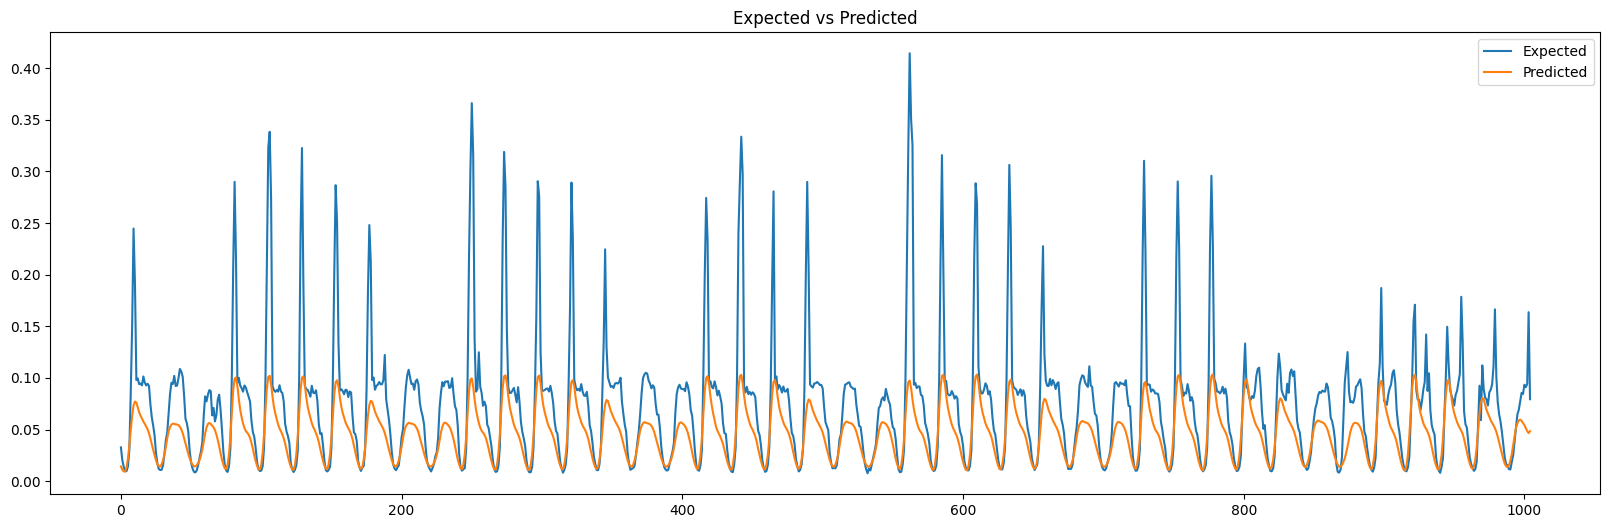

0.002748623276251131

In [ ]:
plot_expected_predicted_data(information["expected"], information["predicted"])
information["mse"]

In [ ]:
parameters = [
    {
        "time_series_data": newDfArray[:100000],
        "window_size": 30,
        "forecast_horizon": 10,
        "test_ratio": 0.1,
        "val_ratio": 0.2,
        "model_size": 10000,
        "epochs": 2000,
        "train_time": 2000,
        "loss_threshold_value": 0.01,
        "verbose": True,
        "max_layer_width": 30,
        "min_layer_width": 10
    }
]
params = parameters[0]
time_series_data = params["time_series_data"]
window_size = params["window_size"]
forecast_horizon = params["forecast_horizon"]
test_ratio = params["test_ratio"]
val_ratio = params["val_ratio"]
model_size = params["model_size"]
epochs = params["epochs"]
train_time = params["train_time"]
loss_threshold_value = params["loss_threshold_value"]
verbose = params["verbose"]
max_layer_width = params["max_layer_width"]
min_layer_width = params["min_layer_width"]

initialTime = time()
X_train, y_train, X_val, y_val, X_test, y_test = prepare_lstm_training_data(time_series_data, window_size, forecast_horizon, test_ratio, val_ratio, frequency=False)
num_input_features = X_train.shape[1]
model = build_balanced_lstm_model(num_input_features, window_size, forecast_horizon, model_size, max_layer_width, min_layer_width)

if verbose:
    model.summary()

if verbose:
    earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
else:
    earlyStop=EarlyStopping(monitor="val_loss",verbose=0,mode='min',patience=3)
loss_threshold = LossThresholdCallback(threshold=loss_threshold_value)
callbacks = [earlyStop, loss_threshold]
if train_time > 0:
    time_limit_callback = TimeLimitCallback(time_limit=train_time)
    callbacks.append(time_limit_callback)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
if not verbose:
    trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks)#, verbose=0)
else:
    trainHistory = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

predicted = model.predict(X_test)
predicted = window_series_to_series(predicted)
predicted = yScaler.inverse_transform(predicted)

expected = window_series_to_series(y_test)
expected = yScaler.inverse_transform(expected)

mse = ((expected - predicted)**2).mean()
totalTime = time() - initialTime
information1 = {"expected": expected, "predicted": predicted, "model": model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse, "input_params": params}

In [ ]:
plot_expected_predicted_data(information1["expected"], information1["predicted"])
information1["mse"]

In [ ]:
# time_series_data = newDfArray[:1000]
# window_size=7
# forecast_horizon=5
# test_ratio=0.1
# val_ratio=0.2
# model_size=8000
# epochs=200
# train_time=300
# loss_threshold_value = 0.01
# verbose=True
# max_layer_width=30
# min_layer_width=10
from pprint import pprint
import pickle as pkl

results_folder = "drive/MyDrive/CS297/Results/FDN/TrainTime"

parameters = [
    {
        "time_series_data": newDfArray[:10000],
        "window_size": 30,
        "forecast_horizon": 10,
        "test_ratio": 0.1,
        "val_ratio": 0.2,
        "model_size": 25000,
        "epochs": 2000,
        "train_time": x,
        "loss_threshold_value": 0.01,
        "verbose": False,
        "max_layer_width": 30,
        "min_layer_width": 10
    }
    for x in range(50, 1000, 20)
]


for index, param in enumerate(parameters):
    print(f"{index}/{len(parameters)}")
    information = fdn_driver(param)
    with open(f"{results_folder}/train_time_{param['train_time']}.pkl", 'wb') as f:
        pkl.dump(information, f)
    pprint(param)
# information = lstm_driver(time_series_data, window_size=10, forecast_horizon=5,
#                 test_ratio=0.1, val_ratio=0.2, model_size=10000, epochs=200,
#                 train_time=300, loss_threshold_value=0.01, verbose=True,
#                 max_layer_width=30, min_layer_width=10)

In [ ]:
# time_series_data = newDfArray[:1000]
# window_size=7
# forecast_horizon=5
# test_ratio=0.1
# val_ratio=0.2
# model_size=8000
# epochs=200
# train_time=300
# loss_threshold_value = 0.01
# verbose=True
# max_layer_width=30
# min_layer_width=10
from pprint import pprint
import pickle as pkl

results_folder = "drive/MyDrive/CS297/Results/LSTM/ModelSize"

parameters = [
    {
        "time_series_data": newDfArray[:10000],
        "window_size": 30,
        "forecast_horizon": 10,
        "test_ratio": 0.1,
        "val_ratio": 0.2,
        "model_size": x,
        "epochs": 200,
        "train_time": 300,
        "loss_threshold_value": 0.01,
        "verbose": True,
        "max_layer_width": 30,
        "min_layer_width": 10
    }
    for x in range(45000, 100000, 5000)
]


for param in parameters:
    information = lstm_driver(param)
    with open(f"{results_folder}/model_size_{param['model_size']}.pkl", 'wb') as f:
        pkl.dump(information, f)
    pprint(param)
# information = lstm_driver(time_series_data, window_size=10, forecast_horizon=5,
#                 test_ratio=0.1, val_ratio=0.2, model_size=10000, epochs=200,
#                 train_time=300, loss_threshold_value=0.01, verbose=True,
#                 max_layer_width=30, min_layer_width=10)

In [ ]:
class LSTM_Module:
    def __init__(self, TimeSeries, WindowSize, ForecastHorizon):
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon

    def seriesToRollingWindowSeries(self, series, windowSize, univariate=False):
        data = []
        if not univariate:
            for i in range(len(series)-windowSize):      # Each window
                features = []
                # for featureNum in range(series.shape[-1]):        # Each feature
                features = series[i:i+windowSize, :]
                data.append(features)
        else:
            for i in range(len(series)-windowSize):      # Each window
                data.append(series[i:i+windowSize])
        return np.array(data)


    def DataPreprocessor(self, trainRatio=0.6, valRatio=0.2):
        self.X = self.TimeSeries
        self.y = self.TimeSeries[:, -1]

        self.X_rolling = self.seriesToRollingWindowSeries(self.X, self.WindowSize)
        self.y_rolling = self.seriesToRollingWindowSeries(self.y, self.ForecastHorizon, univariate=True)
        self.X_rolling = self.X_rolling[:-self.ForecastHorizon]
        self.y_rolling = self.y_rolling[self.WindowSize:]

        trainSplitIndex = int(len(self.X)*trainRatio)
        valSplitIndex = int(len(self.X)*(trainRatio+valRatio))

        self.X_train, self.y_train = self.X_rolling[:trainSplitIndex], self.y_rolling[:trainSplitIndex]
        self.X_val, self.y_val = self.X_rolling[trainSplitIndex:valSplitIndex], self.y_rolling[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X_rolling[valSplitIndex:], self.y_rolling[valSplitIndex:]


    def TrainSetup(self, lstmUnits, denseUnits):
        self.model = Sequential()
        self.model.add(LSTM(units=lstmUnits, activation='relu', return_sequences=True, input_shape=(self.WindowSize, self.X_train.shape[2])))
        # self.model.add(LSTM(units=lstmUnits, activation='relu', input_shape=(self.WindowSize, self.X_train.shape[2])))
        self.model.add(LSTM(units=lstmUnits, activation='relu'))
        self.model.add(Dense(units=denseUnits))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=denseUnits))
        self.model.add(Dense(self.ForecastHorizon))
        optimizer = AdamW(0.0001)
        self.model.compile(optimizer=optimizer, loss='mse')
        self.model.summary()


    def plot_results(self, actual, preds, image_path=None, title_suffix=None):
        """
        Plots training data in blue, actual values in red, and predictions in green,
        over time.
        """
        fig, ax = plt.subplots(figsize=(20,6))
        plot_actual = actual[1:]
        plot_preds = preds[1:]
        ax.plot(plot_actual, label='Expected')
        ax.plot(plot_preds, label='Predicted')
        if title_suffix==None:
            ax.set_title('Predictions vs. Actual')
        else:
            ax.set_title(title_suffix)
        ax.legend()
        plt.show()


    def evaluate(self, expected, predicted, scaler):
        self.plot_results(expected, predicted, title_suffix="Window Size={WindowSize} Forecast Horizon={ForecastHorizon}".format(WindowSize=self.WindowSize, ForecastHorizon=self.ForecastHorizon))
        mse = ((expected - predicted)**2).mean()
        print("MSE="+str(mse))

    def driver(self, trainRatio, valRatio, lstmUnits, denseUnits, epochs):
        initialTime = time()
        self.DataPreprocessor(trainRatio, valRatio)
        self.TrainSetup(lstmUnits, denseUnits)
        trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val))
        totalTime = time() - initialTime

        predicted = self.model.predict(self.X_test)
        print("Predicted:", predicted.shape)
        predicted = predicted[::self.ForecastHorizon]
        predicted = predicted.reshape(predicted.shape[0]*predicted.shape[1], 1)
        predicted = yScaler.inverse_transform(predicted)

        expected = self.y_test[::self.ForecastHorizon]
        print("Expected:", predicted.shape)
        expected = expected.reshape(expected.shape[0]*expected.shape[1], 1)
        expected = yScaler.inverse_transform(expected)


        print(self.X_test.shape, self.y_test.shape)
        print(expected.shape, predicted.shape)

        mse = ((expected - predicted)**2).mean()

        information = {"expected": expected, "predicted": predicted, "model": self.model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
        return information

In [ ]:
TimeSeries = df.values[:10000]

In [ ]:
inputParameters = [
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    }
]


In [ ]:
outputs = []
for index, params in enumerate(inputParameters):
    tmp = {"inputParameters": params, "runs":[]}
    for i in range(5):
        lstmModule = LSTM_Module(params["Data"], params["WindowSize"], params["ForecastHorizon"])
        information = lstmModule.driver(params["TrainRatio"], params["ValRatio"], params["LstmUnits"], params["DenseUnits"], params["Epochs"])
        tmp["runs"].append(information)
    outputs.append(tmp)
    with open("outputs_"+str(index)+"_"+str(len(inputParameters))+".pkl", "wb") as f:
        pkl.dump(outputs, f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 2)             64        
                                                                 
 lstm_1 (LSTM)               (None, 2)                 40        
                                                                 
 dense (Dense)               (None, 3)                 9         
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 5)                 20        
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (5

In [ ]:
!cp outputs*.pkl drive/MyDrive/CS297/Demo3/LstmResults

In [ ]:
data = None
with open("drive/MyDrive/CS297/Demo3/LstmResults/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

0.004059782665448207 85.33331151008606
----------------------------------------------------------------------------------------------------
0.004574057992917499 145.04905767440795
----------------------------------------------------------------------------------------------------
0.004420039431378797 262.6924509525299
----------------------------------------------------------------------------------------------------
0.004545643978551593 73.94522261619568
----------------------------------------------------------------------------------------------------
0.0048202620244675665 178.29667301177977
----------------------------------------------------------------------------------------------------
0.004721375253364612 286.2614110946655
----------------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
n_steps_out=1
tf.random.set_seed(42)

# model = Sequential()
# # model.add(LSTM(units=8, activation='relu', return_sequences=True, input_shape=(100, X_train.shape[2])))
# model.add(LSTM(units=4, activation='relu', return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
# model.add(LSTM(units=4, activation='relu'))
# model.add(Dense(units=4))
# model.add(Dropout(0.2))
# model.add(Dense(units=8))
# model.add(Dense(n_steps_out))
# optimizer = AdamW(0.0001)
# model.compile(optimizer=optimizer, loss='mse')
# model.summary()


# model = Sequential()
# # model.add(LSTM(units=8, activation='relu', return_sequences=True, input_shape=(100, X_train.shape[2])))
# # model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
# model.add(LSTM(units=64, input_shape=(WindowSize, X_train.shape[2])))
# # model.add(LSTM(units=4, activation='relu'))
# model.add(Dense(units=4))
# model.add(Dropout(0.2))
# model.add(Dense(units=8))
# model.add(Dense(n_steps_out))
# optimizer = AdamW(0.0001)
# model.compile(optimizer=optimizer, loss='mse')
# model.summary()

# model = keras.Sequential()
# model.add(keras.layers.LSTM(64, input_shape=(WindowSize, X_train.shape[2])))
# model.add(keras.layers.Dense(1))
# model.compile(loss="mae", optimizer="adam")


model = Sequential()
model.add(LSTM(units=8, return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
model.add(LSTM(units=8))
model.add(Dense(units=8))
model.add(Dropout(0.2))
model.add(Dense(units=8))
model.add(Dense(ForecastHorizon))
optimizer = AdamW(0.0001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 8)             416       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 10)                90        
                                                                 
Total params: 1194 (4.66 KB)
Trainable params: 1194 (4.6

In [ ]:
t = time()
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val))
print("Time taken:", time()-t)

Epoch 1/20
250/250 [==============================] - 7s 12ms/step - loss: 0.0180 - val_loss: 0.0295
Epoch 2/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0084 - val_loss: 0.0239
Epoch 3/20
250/250 [==============================] - 3s 12ms/step - loss: 0.0071 - val_loss: 0.0225
Epoch 4/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0067 - val_loss: 0.0218
Epoch 5/20
250/250 [==============================] - 2s 9ms/step - loss: 0.0065 - val_loss: 0.0215
Epoch 6/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0064 - val_loss: 0.0212
Epoch 7/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0062 - val_loss: 0.0209
Epoch 8/20
250/250 [==============================] - 2s 9ms/step - loss: 0.0061 - val_loss: 0.0207
Epoch 9/20
250/250 [==============================] - 3s 12ms/step - loss: 0.0060 - val_loss: 0.0205
Epoch 10/20
250/250 [==============================] - 2s 10ms/step - loss: 0.0059 - val_loss: 0

In [ ]:
def plot_results(actual, preds, image_path=None, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    plot_actual = actual[1:]
    plot_preds = preds[1:]
    ax.plot(plot_actual, label='actual')
    ax.plot(plot_preds, label='preds')
    if title_suffix==None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

31/31 [==============================] - 2s 5ms/step


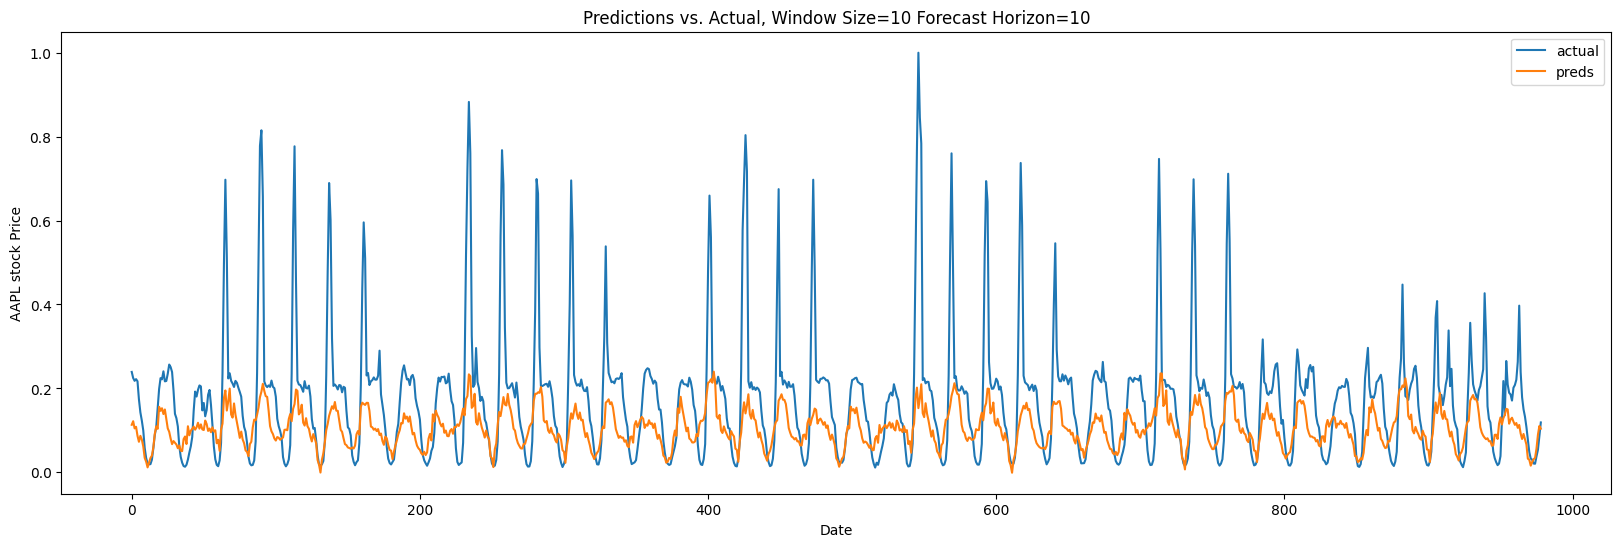

RMSE: 0.14421414036541372


In [ ]:
testPredictions = model.predict(X_test)
testPredictions = testPredictions[::ForecastHorizon]
testPredictions = testPredictions.reshape(testPredictions.shape[0]*testPredictions.shape[1])


y_test_tmp = y_test[::ForecastHorizon]
y_test_tmp = y_test_tmp.reshape(y_test_tmp.shape[0]*y_test_tmp.shape[1])

plot_results(y_test_tmp, testPredictions, title_suffix="Window Size={WindowSize} Forecast Horizon={ForecastHorizon}".format(WindowSize=WindowSize, ForecastHorizon=ForecastHorizon))
mse = ((y_test_tmp- testPredictions)**2).mean()
print("RMSE:", mse**0.5)

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

class FourierInformedTimeSeriesForecaster:


    def __init__(self, TimeSeries, WindowSize, ForecastHorizon, MaskPercentage):
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None

    def seriesToRollingWindowSeries(self, series, windowSize, univariate=False):
        data = []
        if not univariate:
            for i in range(len(series)-windowSize):      # Each window
                features = []
                for featureNum in range(series.shape[-1]):        # Each feature
                    features.append(series[i:i+windowSize, featureNum])
                data.append(features)
        else:
            for i in range(len(series)-windowSize):      # Each window
                data.append(series[i:i+windowSize])
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        # global self.TargetComplexShape
        self.TargetComplexShape = ComplexValuedArray.shape
        # print(TARGET_COMPLEX_SHAPE)
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, mask=True, maskPercentage=0):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if mask:
                    maskIndex = int(len(frequencyMagnitudes)*(maskPercentage))
                    frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            # timeSeries.append(rollingWindowTimeSeries[i][-1])
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, univariate=False, trainRatio=0.6, valRatio=0.2, pca=True, pcaComponents=0):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))

        self.rollingWindowTimeSeries = self.seriesToRollingWindowSeries(self.TimeSeries, self.WindowSize)
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage)

        self.X, self.y = self.rollingWindowFrequencies[:-1], self.rollingWindowFrequencies[:, -1][1:]
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if pca:
            covar_matrix = PCA(n_components = pcaComponents)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]


    def TrainSetup(self, hiddenLayers, hiddenUnits):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        self.model.summary()

    def plot_results(self, actual, preds, image_path=None, title_suffix=None):
        """
        Plots training data in blue, actual values in red, and predictions in green,
        over time.
        """
        fig, ax = plt.subplots(figsize=(20,6))
        plot_actual = actual[1:]
        plot_preds = preds[1:]
        ax.plot(plot_actual, label='Expected')
        ax.plot(plot_preds, label='Predicted')
        if title_suffix==None:
            ax.set_title('Predictions vs. Actual')
        else:
            # ax.set_title(f'Predictions vs. Actual, {title_suffix}')
            ax.set_title(title_suffix)
        ax.set_xlabel('Date')
        # ax.set_ylabel(xlabel)
        ax.legend()
        plt.show()

    def driver(self, univariate=False, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, pca=True, pcaComponents=20):
        initialTime = time()
        self.DataPreprocessor(univariate, trainRatio, valRatio, pca=pca, pcaComponents=pcaComponents)
        self.TrainSetup(hiddenLayers, hiddenUnits)
        trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val))
        totalTime = time() - initialTime

        testPredictions = self.model.predict(self.X_test)

        pred = self.rollingWindowFrequenciesToRollingWindowTimeSeries(testPredictions, self.TargetComplexShape)
        actual = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)

        pred = self.rollingWindowTimeSeriesToTimeSeries(pred, forecastHorizon=1)
        actual = self.rollingWindowTimeSeriesToTimeSeries(actual, forecastHorizon=1)


        predicted = self.model.predict(self.X_test)
        predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)
        # print("Predicted:", predicted.shape)
        predicted = predicted.reshape(predicted.shape[0], 1)
        predicted = yScaler.inverse_transform(predicted)

        expected = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)
        expected = self.rollingWindowTimeSeriesToTimeSeries(expected, forecastHorizon=self.ForecastHorizon)
        # print("Expected:", expected.shape)
        expected = expected.reshape(expected.shape[0], 1)
        expected = yScaler.inverse_transform(expected)


        # print(self.X_test.shape, self.y_test.shape)
        # print(expected.shape, predicted.shape)

        mse = ((expected - predicted)**2).mean()

        information = {"expected": expected, "predicted": predicted, "model": self.model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
        return information

In [ ]:
inputParameters = [
    {
        "Data": TimeSeries,
        "WindowSize": 20,
        "ForecastHorizon": 20,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 5,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 5,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    }
]

outputs = []

In [ ]:
!rm outputs*.pkl

In [ ]:
outputs = []
for index, params in enumerate(inputParameters):
    tmp = {"inputParameters": params, "runs":[]}
    for i in range(5):
        fourierModule = FourierInformedTimeSeriesForecaster(params["Data"], params["WindowSize"], params["ForecastHorizon"], params["MaskPercentage"])
        information = fourierModule.driver(trainRatio=params["TrainRatio"], valRatio=params["ValRatio"],
                        hiddenLayers=params["HiddenLayers"], hiddenUnits=params["HiddenUnits"], epochs=params["Epochs"], pca=params["Pca"], pcaComponents=params["PcaComponents"])
        tmp["runs"].append(information)
    outputs.append(tmp)
    with open("outputs_"+str(index)+"_"+str(len(inputParameters))+".pkl", "wb") as f:
        pkl.dump(outputs, f)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 2)                 102       
                                                                 
 dense_91 (Dense)            (None, 40)                120       
                                                                 
Total params: 222 (888.00 Byte)
Trainable params: 222 (888.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 1s 2ms/step - loss: 0.2642 - val_loss: 0.4251
Epoch 2/20
250/250 [==============================] - 0s 2ms/step - loss: 0.1497 - val_loss: 0.3468
Epoch 3/20
250/250 [==============================] - 1s 2ms/step - loss: 0.1172 - val_loss: 0.2926
Epoch 4/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0922 - val_loss: 0.2456
Epoch 5/20


In [ ]:
!cp outputs*.pkl drive/MyDrive/CS297/Demo3/FourierResults

In [ ]:
data = None
with open("drive/MyDrive/CS297/Demo3/FourierResults/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

0.002898320554463442 19.44711799621582
----------------------------------------------------------------------------------------------------
0.00321197476207821 21.681945610046387
----------------------------------------------------------------------------------------------------
0.0037497871382869133 22.300878286361694
----------------------------------------------------------------------------------------------------
0.001287440008156017 17.918078804016112
----------------------------------------------------------------------------------------------------
0.0033146734237167142 23.211851930618288
----------------------------------------------------------------------------------------------------
0.003472462963883508 24.02676692008972
----------------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
# train = pd.read_csv("data/train.csv",
#                  parse_dates=["datetime"],
#                  index_col=["datetime"])
# train.head()
df = df[[c for c in df if c not in ['values']] + ['values']]
train = df
from sklearn.preprocessing import MinMaxScaler

# Assuming 'train' and 'test' are your dataframes and 'nat_demand' is a column to exclude from scaling
# columns_to_scale = [col for col in train.columns if col != 'nat_demand']

# Create a scaler and fit it only on the columns to be scaled
scaler = MinMaxScaler()
scaler.fit(train)

# Transform the selected columns in both the train and test sets
train_scaled = train.copy()
train_scaled = scaler.transform(train)



# X = train_scaled[:, :-1]#[:10000]
# y = train_scaled[:, -1]#[:10000]

# # X = train.values[:, 1:][:10000]
# # y = train.values[:, 0][:10000]

# forecastHorizon = 10
# X = X[:-forecastHorizon]
# y = y[forecastHorizon:]

In [ ]:
WindowSize = 100
ForecastHorizon = 100
MaskPercentage = 0.00
# TimeSeries = dataset.values #train #.values
# TimeSeries = train.values #.values
TimeSeries = train_scaled
TARGET_COMPLEX_SHAPE = None
FrequenciesToConsider = int(WindowSize*(1-MaskPercentage))

univariate = False
trainRatio = 0.8
valRatio = 0.1
FREQUENCIES_MEASURED = None

In [ ]:
ft.X_train.shape

(8000, 800)

In [ ]:
ft = FourierInformedTimeSeriesForecaster(train_scaled, WindowSize, ForecastHorizon, MaskPercentage=0.0)
ft.DataPreprocessor(univariate, trainRatio, valRatio, pca=False, pcaComponents=20)
ft.TrainSetup(1, 3)
trainHistory = ft.model.fit(ft.X_train, ft.y_train, epochs=20, validation_data=(ft.X_val, ft.y_val))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 3)                 3003      
                                                                 
 dense_37 (Dense)            (None, 200)               800       
                                                                 
Total params: 3803 (14.86 KB)
Trainable params: 3803 (14.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 1s 3ms/step - loss: 0.7473 - val_loss: 1.2444
Epoch 2/20
250/250 [==============================] - 1s 2ms/step - loss: 0.2914 - val_loss: 0.9563
Epoch 3/20
250/250 [==============================] - 0s 2ms/step - loss: 0.2525 - val_loss: 0.8267
Epoch 4/20
250/250 [==============================] - 1s 2ms/step - loss: 0.2148 - val_loss: 0.7281
Epoch 5/20
250/2

29/29 [==============================] - 0s 2ms/step


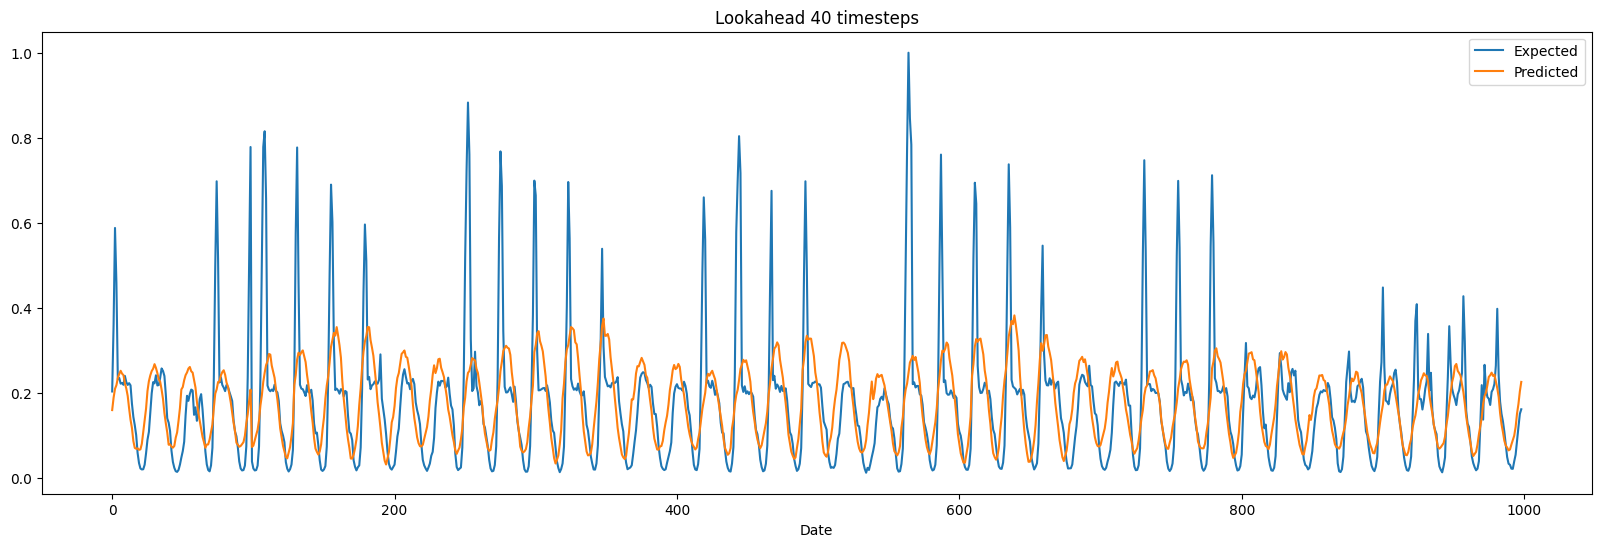

RMSE: 0.12370479581845352


In [ ]:
testPredictions = ft.model.predict(ft.X_test)
pred = ft.rollingWindowFrequenciesToRollingWindowTimeSeries(testPredictions, ft.TargetComplexShape)
pred = ft.rollingWindowTimeSeriesToTimeSeries(pred, forecastHorizon=10)
actual = ft.rollingWindowFrequenciesToRollingWindowTimeSeries(ft.y_test, ft.TargetComplexShape)
actual = ft.rollingWindowTimeSeriesToTimeSeries(actual, forecastHorizon=10)

ft.plot_results(actual, pred, title_suffix='Lookahead 40 timesteps')
mse = ((actual- pred)**2).mean()
print("RMSE:", mse**0.5)